<a href="https://colab.research.google.com/github/LivingstonTardzenyuy/Deep-Learning-with-TensorFlow/blob/main/05_transfer_learning_in_tensorflow_part_2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 2: Fine-tuning.

In the previous notebook, we covered transfer learning feature extraction, now it's time to learn about a new kind of transfer learning: **fine-tuning**

In [ ]:
# Check if we're using a GPU.
!nvidia-smi

Sat Dec 21 05:01:12 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Creating helper functions

In previous notebooks, we've created a bunch of helper functions, now we could rewrite them all, howerver, this is tedious

# Let's get some data.

This time we're going to see how we can use the pretrained models withing tf.keras.applications and apply them to our own problem (recognizing images of food).

Link: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [ ]:
# Function to unzip our data.
def unzip_data(filename):
  """
    Unzips filename into current working directory.

  Args:
    filename (str): a zip file path.
  """
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()

In [ ]:
import zipfile
import os
# Get 10% of training data of 10 classes of Food101.

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2024-12-21 05:01:12--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.217.207, 108.177.11.207, 108.177.12.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.217.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   118MB/s    in 1.4s    

2024-12-21 05:01:14 (118 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# Get 10 percent
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}")


walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent
There are 10 directories and 0 images in '10_food_classes_10_percent/train
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream
There are

In [ ]:
 # Create a training and test directory path.
 train_path = "10_food_classes_10_percent/train"
 test_path = "10_food_classes_10_percent/test"

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory


IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_data_10_percent = image_dataset_from_directory(directory =train_path, image_size = IMG_SIZE, label_mode = "categorical", batch_size= BATCH_SIZE)
test_data = image_dataset_from_directory(directory = test_path, image_size = IMG_SIZE, label_mode = "categorical", batch_size= BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [ ]:
# Check out the class names of our dataset.
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
# See an example of a batch of data.
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[ 34.642857   55.642857   72.64286  ]
   [ 34.142857   53.142857   70.14285  ]
   [ 32.290817   49.357143   64.581635 ]
   ...
   [ 14.005095   14.005095    6.0050945]
   [ 12.908159   12.908159    4.9081597]
   [ 12.         12.          4.       ]]

  [[ 33.785713   52.785713   69.78572  ]
   [ 34.010204   53.010204   68.0102   ]
   [ 35.07143    52.285717   67.85715  ]
   ...
   [ 15.872469   15.872469    7.872469 ]
   [ 14.857117   14.857117    6.8571167]
   [ 11.311157   11.311157    3.3111572]]

  [[ 36.642857   55.42857    70.21429  ]
   [ 35.341835   54.12755    68.91326  ]
   [ 34.045918   51.64286    66.92347  ]
   ...
   [ 15.83165    15.83165     7.83165  ]
   [ 15.770405   15.770405    7.7704053]
   [ 14.5050745  14.5050745   6.5050745]]

  ...

  [[  1.          1.          1.       ]
   [  1.          1.          1.       ]
   [  1.          1.          1.       ]
   ...
   [  1.          1.          1.       ]
   [  1.          1.          1.       ]
   [ 

## Model 0: Building a transfer learning model using the Keras Functional API.

The sequential API is straight-forward, it runs our layers in sequential order.

But the Functional API gives flexibility with our model.

In [ ]:
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  """
  Creates a TensorBoard callback instand to store log files.

  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"

  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [ ]:
# 1. Create the base model with tf.keras.application.

base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,     # because we want to include our own layer.
    )

# 2. Freeze the base model (so the underlying pre-trained patterns areint' updated)
base_model.trainable = False   # don't train yet.

# 3. Create inputs into our model.
inputs = tf.keras.layers.Input(shape=(224,224,3), name = 'input_layer')

# 4. If using ResNet50V2 you will need to normalize inputs.
# x = tf.keras.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base model.
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the data model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name = 'global_average_pooling_layer')(x)
print(f"Shape after Global Average Pooling: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation='softmax', name = 'output_layer')(x)

# 8. Combine the inputs with the outputs into a model.
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile for the model.
model_0.compile(
    loss = "categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)


#10. Fit the model.
history_0 = model_0.fit(
    train_data_10_percent,
    epochs = 5,
    steps_per_epoch = len(train_data_10_percent),
    validation_data = test_data,
    validation_steps = len(test_data),
    callbacks = [
        create_tensorboard_callback(dir_name = "transfer_learning",
                                    experiment_name = "model_0_transfer_learning")
    ]
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after Global Average Pooling: (None, 1280)
Saving TensorBoard log files to: transfer_learning/model_0_transfer_learning/20241221-050139
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.1885 - loss: 2.2460 - val_accuracy: 0.6696 - val_loss: 1.4422
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/5


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


24/24 ━━━━━━━━━━━━━━━━━━━━ 45s 296ms/step - accuracy: 0.6939 - loss: 1.3270 - val_accuracy: 0.7600 - val_loss: 1.0046
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 242ms/step - accuracy: 0.7945 - loss: 0.9359 - val_accuracy: 0.7960 - val_loss: 0.8100


In [ ]:
# Evaluate the full test dataset.

model_0.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.7963 - loss: 0.8004


[0.8100214004516602, 0.7960000038146973]

In [ ]:
# Different type of layers.
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_layer
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activati

In [ ]:
base_model.summary()

Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None, None, 3)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, None, None, 3)  │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, None, None, 3)  │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, None, None, 3)  │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, None, None, 3)  │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, None, None, 32) │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, None, None, 32) │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, None, None, 32) │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, None, None, 32) │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, None, None, 32) │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, None, None, 32) │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,049,571 (15.45 MB)

## Getting a feature vector from a trained moel.

Let's demonstrate the Global Average Pooling 2D layer...

We have a tensor after our model goes through 'base_model' of shape (None, 7,7, 1280)...

But then when it passes through GlobalAveragePooling2D, it turns into (None, 1280).

Let's use a similar shaped tensor of (1,4,4,3) and then pass it to GlobalAveragePooling2D

In [ ]:
# Define the input shape.
import tensorflow as tf

input_shape = (1,4,4,3)

# Create a random tensor.
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer.
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D gloabl average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shape of the different tensors.
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of global average pooled 2D tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D gloabl average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of global average pooled 2D tensor: (1, 3)


In [ ]:
# Let's use 'GlobalMaxPool2D' ...

input_shape = (1,4,4,3)

tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

global_max_pooled_tensor = tf.keras.layers.GlobalMaxPool2D()(input_tensor)


# Check the shape of the different tensors.
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of global average pooled 2D tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

Shape of input tensor: (1, 4, 4, 3)
Shape of global average pooled 2D tensor: (1, 3)


## Running a series of transfer learning experiments.

We've seen the great result transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data.... how about we setup a bunch of experiments to find out:

1. 'model_1' - use feature extraction transfer learning with 1% of the training data with data augmentation.

2. 'model_2' - use feature extraction transfer learning with 10% of the training with data augmentation.

3. 'model_3' - use fine-tuning transfer learning on 10% of the training data with data augmentation.
4. 'model_4' - use fine-tuning transferl earning with data augmentation with 100% of data.

**Note:** Throughout all experiments the same test dataset will be used to evlulate our model... this ensures consistency across evalution metrics.

In [ ]:
# Download and unzip data - preprocessed from Food101.

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

unzip_data("10_food_classes_1_percent.zip")

--2024-12-21 05:03:32--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.134.207, 142.251.107.207, 74.125.196.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.134.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   159MB/s    in 0.8s    

2024-12-21 05:03:33 (159 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [ ]:
# Create training and test dirs.

train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [ ]:
# How many images are we working with ?.
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent
There are 10 directories and 0 images in '10_food_classes_1_percent/train
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream
There are 10 directories and 0 

In [ ]:
# Setup data loaders
IMG_SIZE = (224,224)
BATCH_SIZE = 32

train_data_1_percent = image_dataset_from_directory(directory = train_dir_1_percent,
                                                    label_mode = "categorical",
                                                    image_size = IMG_SIZE,
                                                    batch_size = BATCH_SIZE
                                                    )

test_data = image_dataset_from_directory(directory = test_dir,
                                          label_mode = "categorical",
                                          image_size = IMG_SIZE,
                                          batch_size = BATCH_SIZE
                                          )

#

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentaiton righ into the model.

To add data augmenation right into our models, we can use the layers inside:

* tf.keras.layers.experimental.preprocessing()

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

def apply_augmentation(img):
  img = layers.RandomFlip('horizontal')(img)
  img = layers.RandomRotation(0.2)(img)
  img = layers.RandomZoom(0.2)(img)
  img = layers.RandomHeight(0.2)(img)
  img =layers.RandomWidth(0.2)(img)
  return img

### Visualize our data augmentation layer(and see what happens to our data)

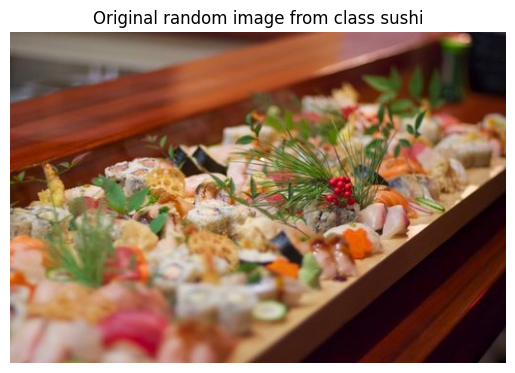

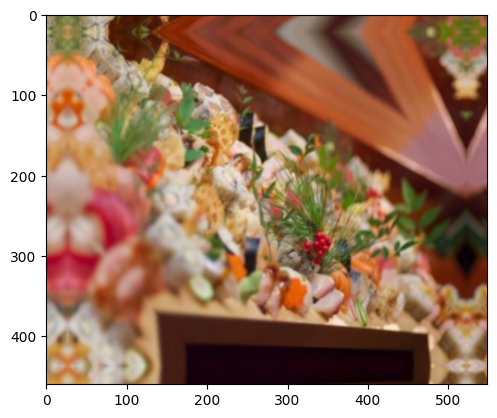

In [ ]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read and plot in the random image.
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class {target_class}")
plt.axis(False);

# Now let's plot our augmented random image.
img = tf.image.resize(img, size=[384, 512])
img = tf.cast(img, dtype=tf.float32)
augmented_img = apply_augmentation(img)  # Apply data augmentation

# Normalize pixel values to [0, 1]
augmented_img = augmented_img / 255.0

plt.figure()
plt.imshow(augmented_img)  # Now you can plot the image using matplotlib

## Model 1. Feature Extraction Transfer Learning on 1% of the data with *Data Augmentation*

In [ ]:
# Setup input shape and base model, freezing the base model layers.

input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(
    include_top = False
)

base_model.trainable = False

# Create input layer.
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer.
x = apply_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it.
x = base_model(x, training=False)

# Pool out features of the base model.
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make the model using inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model.
model_1.compile(
    loss = "categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)


# Fit the model.
model_1.fit(
    train_data_1_percent.repeat(),
    epochs = 5,
    steps_per_epoch = len(train_data_1_percent),
    validation_data = test_data,
    validation_steps = int(0.25 * len(test_data)),
    callbacks = [
        create_tensorboard_callback(dir_name = "transfer_learning",
                                    experiment_name = "model_1_transfer_learning")
    ]
)

Saving TensorBoard log files to: transfer_learning/model_1_transfer_learning/20241221-051816
Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.1496 - loss: 2.3239 - val_accuracy: 0.2138 - val_loss: 2.1982
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 714ms/step - accuracy: 0.3023 - loss: 2.0775 - val_accuracy: 0.2336 - val_loss: 2.1087
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 707ms/step - accuracy: 0.4369 - loss: 1.9229 - val_accuracy: 0.3174 - val_loss: 1.9959
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 721ms/step - accuracy: 0.5150 - loss: 1.7622 - val_accuracy: 0.4194 - val_loss: 1.8988
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.5820 - loss: 1.6346 

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.5722 - loss: 1.6388 - val_accuracy: 0.4559 - val_loss: 1.7955


In [ ]:
model_1.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip_2 (RandomFlip)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_2 (RandomRotation)   │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom_2 (RandomZoom)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_height_2 (RandomHeight)       │ (None, None, 224, 3)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_width_2 (RandomWidth)         │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, None, None, 1280)    │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling_layer         │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 10)                  │          12,810 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,088,003 (15.59 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 25,622 (100.09 KB)

In [ ]:
# evaluate on the full test data.
results_1_percent_data_aug = model_1.evaluate(test_data)

results_1_percent_data_aug

79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - accuracy: 0.4205 - loss: 1.8337


[1.8341548442840576, 0.42320001125335693]

In [ ]:
# How does model go with Data Augmentation ?.

plot_loss_curves(history_1_percent_data_aug)

NameError: name 'plot_loss_curves' is not defined